# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка данных

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import lightgbm as lgb
import xgboost as xgb
import category_encoders as ce

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [2]:
# чтение файла с данными и сохранение в переменную df
try:
    df = pd.read_csv('C:/Users/79853/Documents/datascience/yandex/Спринт12/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv') # загрузка онлайн

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [5]:
columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'DateCreated']
for column in columns:
    print("\033[1m" + column + "\033[0;0m")
    print(sorted(df.loc[df[column].notnull(), column].unique()))
    print()

VehicleType
['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']

Gearbox
['auto', 'manual']

Model
['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos'

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Признаки**
- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **NotRepaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя

**Целевой признак**
- **Price** — цена (евро)

In [7]:
# подсчёт явных дубликатов
df.duplicated().sum()

4

In [8]:
# процент пропущенных значений в датасете
df.isnull().sum() / df.shape[0] * 100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [9]:
sorted(df.loc[df['RegistrationYear'].notnull(), 'RegistrationYear'].unique())

[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

In [10]:
sorted(df.loc[df['Power'].notnull(), 'Power'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


В датасете представлены анкеты за период 2014-2016 гг.

В датасете присутствуют количественные и категориальные переменные. 

В названиях полей нарушен стиль написания - строчные буквы сочетаются с прописными. Необходимо привести названия полей к нижнему регистру и к "змеиному стилю".

Выявлены некорректные значения в следующих полях:

- поле `RegistrationYear` (год регистрации автомобиля) - диапазон [1000, 1800] (верхняя граница интервала взята условно, выделены значения до XX века),  [2066, 9999].
- поле `RegistrationMonth` (месяц регистрации автомобиля) - значение 0.
- поле `Power` (мощность (л. с.)) - значение 0, диапазон [2000, 20000] (нижняя граница интервала взята условно, 2000 л.с. - наивысшая известная мощность автомобиля). 
- поле `Price` (цена (евро)) - значение 0.

Для перечисленных полей необходимо убрать выбросы, т.о., возможно, получится избавиться от некорректных значений.

В полях `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` есть пропуски:
- пропуски в поле `Model` (модель автомобиля) и в поле `NotRepaired` (была машина в ремонте или нет) заполним значением **'unknown'**.
- пропуски в поле `VehicleType` (тип автомобильного кузова) и `Gearbox` (тип коробки передач), `FuelType` (тип топлива) заполним самым часто встречающимся значением (модой) для определенной модели автомобиля.

Выявлено 4 случая явных дубликатов. Их необходимо удалить.

Неявные дубликаты не выявлены.

Поле `DateCreated` (дата создания анкеты) необходимо перевести в формат **datetime**.

Поле `NumberOfPictures` заполнено нулями, его можно удалить. Признаки `PostalCode` (почтовый индекс владельца анкеты (пользователя)), `LastSeen` (дата последней активности пользователя), `DateCrawled` (дата скачивания анкеты из базы), `RegistrationMonth` (месяц регистрации автомобиля) не влияют на целевой признак, их можно удалить.

Для обучения моделей категориальные признаки необходимо преобразовать в численные.

### Предобработка данных

In [11]:
# удаление полей
df = df.drop(['NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCrawled', 'RegistrationMonth'], axis=1)

In [12]:
# приведение названий полей к правильному стилю
df.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer',
              'fuel_type', 'brand', 'not_repaired', 'date_created']

In [13]:
# изменение типа данных c object на datetime64 для поля date_created (дата создания анкеты)
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%dT%H:%M:%S')
df['date_created'] = pd.DatetimeIndex(df['date_created']).year  # оставим только год публикации

Оставили только год создания анкеты, т.к. можно предположить, что цены на авто менялись в разные годы: росли или снижались.

Добавим в датасет поле `age` (возраст автомобиля), предположительно, этот признак должен влиять на цену авто.

In [14]:
df['age'] = df['date_created'] - df['registration_year']

In [15]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,date_created,age
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016,23
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016,5
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016,12
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016,15
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016,8


#### Обработка явных дубликатов

In [16]:
# подсчёт явных дубликатов
df.duplicated().sum()

45037

После исключения нескольких полей, не влияющих на целевой признак, число дубликатов значительно выросло. Этому может быть несколько причин:
- одни и те же анкеты добавлялись на сервис несколько раз (разные значения `DateCreated` (дата создания анкеты)), 
- одни и те же анкеты были скачаны из базы несколько раз (разные значения `DateCrawled` (дата скачивания анкеты из базы)).

Удалим дубликаты из датасета.

In [17]:
# удаление явных дубликатов
df = df.drop_duplicates().reset_index(drop=True)

In [18]:
# проверка на отсутствие дубликатов
df.duplicated().sum()

0

#### Обработка некорректных значений

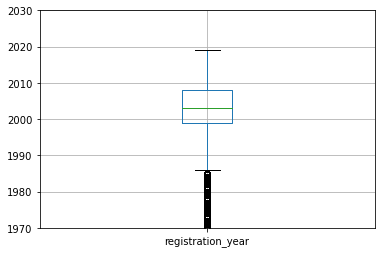

In [19]:
# диаграмма размаха registration_year (год регистрации)
df.boxplot(column='registration_year')
plt.ylim(1970, 2030)
plt.show()

Оставим значения в интервале 1985-2016 гг. (т.к. в датасете представлены анкеты до апреля 2016 года)

In [20]:
df = df.loc[(df.registration_year > 1984) & (df.registration_year < 2017), :]

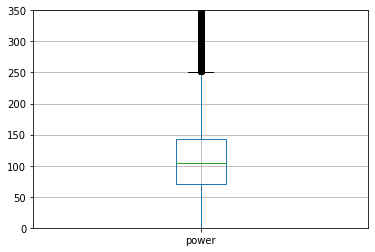

In [21]:
# диаграмма размаха power (мощность (л. с.))
df.boxplot(column='power')
plt.ylim(0, 350)
plt.show()

В поле `power` (мощность (л. с.)) уберем значения выше 250. Также уберем значение 0.

In [22]:
df = df.loc[(df.power < 251) & (df.power > 0), :]

<AxesSubplot:>

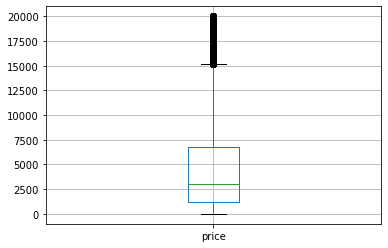

In [23]:
# диаграмма размаха price (цена (евро))
df.boxplot(column='price')

В поле `price` (цена (евро)) уберем значения выше 16000. Также уберем значение 0.

In [24]:
df = df.loc[(df.price < 16001) & (df.price > 0), :]

#### Обработка пропусков

In [25]:
# заполнение пропусков в полях model и not_repaired значением 'unknown'
df.loc[df.model.isnull(), 'model'] = 'unknown'
df.loc[df.not_repaired.isnull(), 'not_repaired'] = 'unknown'

In [26]:
# пропущенные значения
df.isnull().sum()

price                    0
vehicle_type         10205
registration_year        0
gearbox               4947
power                    0
model                    0
kilometer                0
fuel_type            14462
brand                    0
not_repaired             0
date_created             0
age                      0
dtype: int64

Заполним пропуски в поле `vehicle_type` (тип автомобильного кузова) и `gearbox` (тип коробки передач), `fuel_type` (тип топлива) самым часто встречающимся значением для определенной модели автомобиля.

In [27]:
df['gearbox'] = df.groupby(['brand','model'])['gearbox'].transform(lambda x: x.fillna(x.mode()[0]))

In [28]:
df['fuel_type'] = df.groupby(['brand','model'])['fuel_type'].transform(lambda x: x.fillna(x.mode()[0]))

In [29]:
df['vehicle_type'] = df.groupby(['brand','model'])['vehicle_type']\
                       .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "unknown"))

In [30]:
df.isnull().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
not_repaired         0
date_created         0
age                  0
dtype: int64

In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,239800.0,4305.175992,3861.333969,1.0,1299.0,2990.0,6390.0,16000.0
registration_year,239800.0,2002.985271,5.755705,1985.0,1999.0,2003.0,2007.0,2016.0
power,239800.0,115.527911,44.708417,1.0,75.0,109.0,143.0,250.0
kilometer,239800.0,128904.065888,36025.649159,5000.0,125000.0,150000.0,150000.0,150000.0
date_created,239800.0,2015.999929,0.008419,2015.0,2016.0,2016.0,2016.0,2016.0
age,239800.0,13.014658,5.755733,0.0,9.0,13.0,17.0,31.0


In [32]:
columns = ['vehicle_type', 'gearbox', 'fuel_type', 'not_repaired']
for column in columns:
    print("\033[1m" + column + "\033[0;0m")
    print(sorted(df.loc[df[column].notnull(), column].unique()))
    print()

vehicle_type
['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']

gearbox
['auto', 'manual']

fuel_type
['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol']

not_repaired
['no', 'unknown', 'yes']



#### Преобразование категориальных признаков

Для обучения моделей категориальные признаки необходимо преобразовать в численные. Для этого используем специальные техники.

Техника **прямого кодирования (OHE)** подходит для преобразования признаков в LinearRegression.

Техника **порядкового кодирования (OrdinalEncoder)** подходит для преобразования признаков в DecisionTree и RandomForest, т.о. эта техника подойдет для моделей градиентного бустинга, которые используют деревья решений в качестве базовых алгоритмов.

Преобразуем данные с помощью двух техник и создадим, соответственно, два новых датасета - **df_ohe** и **df_ordinal**.

In [33]:
# список категориальных переменных в датасете
cat_features = list(df.select_dtypes(include=['object']).columns)
cat_features

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [34]:
# преобразование с помощью техники OHE
df_ohe = pd.get_dummies(df, columns=cat_features, drop_first=True)
df_ohe.head()

,price,registration_year,power,kilometer,date_created,age,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
2,9800,2004,163,125000,2016,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,2016,15,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,2016,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,2016,21,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,2016,12,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# преобразование с помощью техник OrdinalEncoder 
ordinal = OrdinalEncoder()

df_ordinal = pd.DataFrame(columns=df.columns)
for column in df.columns:
    if column not in cat_features:
        df_ordinal[column] = df[column]

        
df_ordinal[cat_features] = ordinal.fit_transform(df[cat_features])


df_ordinal.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,date_created,age
2,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,1.0,2016,12
3,1500,5.0,2001,1.0,75,116.0,150000,6.0,38.0,0.0,2016,15
4,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0,2016,8
5,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,2.0,2016,21
6,2200,1.0,2004,1.0,109,8.0,150000,6.0,25.0,0.0,2016,12


## Обучение моделей

Обучим несколько моделей градиентного бустинга:
- **LGBMRegressor()**,
- **CatBoostRegressor()**,
- **XGBRegressor()**.

Рассмотрим качество и скорость работы моделей градиентного бустинга по следующему алгоритму:
- обучим модель со значениями гиперпараметров по умолчанию;
- подберем значения нескольких гиперпараметров, которые влияют как на качество, так и на скорость обучения, с помощью GridSearchCV();
- обучим модель с подобранными гиперпараметрами;
- попробуем увеличить скорость работы модели корректировкой гиперпараметров;
- попробуем увеличить скорость работы модели отбором признаков.

Для сравнения также посмотрим на результаты линейной модели **LinearRegression()**.

In [36]:
# функция для разделения датасета на обучающую и тестовую выборки, на признаки (features) и целевой признак (target)
def split_df(data, target):
    # разделение в соотношении 3:1
    df_train, df_test = train_test_split(data, test_size=0.25, random_state=123) 

    train_features = df_train.drop([target], axis=1)
    train_target = df_train[target]

    test_features = df_test.drop([target], axis=1)
    test_target = df_test[target]
    
    
    return train_features, train_target, test_features, test_target

In [37]:
# функция для определения гиперпараметров модели
def grid_search(model, params):
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring=scorer)
    grid_cv.fit(train_features, train_target)
    print('Гиперпараметры: ', grid_cv.best_params_)
    print('RMSE:', int(-grid_cv.best_score_))
    return grid_cv.best_params_

In [38]:
# функция для обучения модели и определения времени обучения
def fit_predict(model, name, importance_features='all'):
    start_fit_time = time.time()
    model.fit(train_features, train_target)
    fit_time = time.time() - start_fit_time
    
    predictions = model.predict(train_features)
    
    global a
    columns = ['model_name', 'model', 'fit_time_sec', 'RMSE', 'importance_features']
    rows = [[name, model, round(fit_time, 1), int(rmse(train_target, predictions)), importance_features]]
    a = pd.DataFrame(data=rows, columns=columns)

In [39]:
# функция для расчета ошибки RMSE
def rmse(target, predictions):
    return mean_squared_error(target, predictions, squared=False)

In [40]:
# функция оценки для использования в GridSearchCV
scorer = make_scorer(rmse, greater_is_better=False)

In [41]:
# таблица для накопления результатов
columns = ['model_name', 'model', 'fit_time_sec', 'RMSE', 'importance_features']
result_tbl = pd.DataFrame(columns=columns)
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features


Значения полей таблицы с результатами:
- **model_name** – название модели,
- **model** – конфигурация модели,
- **fit_time_sec** – время обучения модели в секундах,
- **RMSE** – среднеквадратическая ошибка на обучающей выборке,
- **importance_features** – количество важных признаков, отобранных для обучения модели (примеры значений: *all* - признаки не отбирались, *10* - было отобрано 10 признаков)

### LGBMRegressor

In [42]:
train_features, train_target, test_features, test_target = split_df(df_ordinal, 'price')

In [43]:
lgbmreg = LGBMRegressor()

In [44]:
fit_predict(lgbmreg, name='lgbmreg')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(random_state=123),0.5,1418,all


In [45]:
%%time
# подбор гиперпараметров для модели
best = grid_search(lgbmreg, params={'num_iterations': [500, 1000], 'max_bin': [255, 455], 'random_state': [123]})

C:\Users\79853\miniconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Гиперпараметры:  {'max_bin': 255, 'num_iterations': 1000}
RMSE: 1353
Wall time: 29.7 s


In [46]:
# модель с подобранными гиперпараметрами
lgbmreg2 = LGBMRegressor(**best)

In [47]:
fit_predict(lgbmreg2, name='lgbmreg2')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(random_state=123),0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all


Уменьшим значения гиперпараметров, чтобы увеличить скорость обучения модели.

In [48]:
lgbmreg3 = LGBMRegressor(num_iterations=500, max_bin=255, random_state=123)

In [49]:
fit_predict(lgbmreg3, name='lgbmreg3')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

C:\Users\79853\miniconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(random_state=123),0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, num_iterations=500,...",1.6,1279,all


Посмотрим на гистограмму распределения важных признаков для модели **lgbmreg2**.

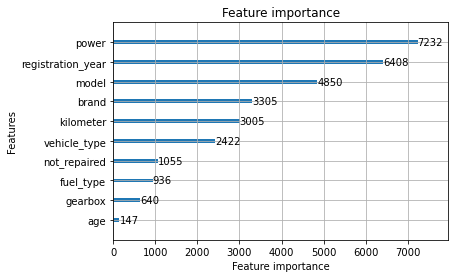

In [50]:
lgb.plot_importance(lgbmreg2);

In [51]:
# таблица признаков в порядке убывания важности
feature_imp = pd.DataFrame({'value':lgbmreg2.feature_importances_,'feature':train_features.columns})\
                .sort_values('value', ascending=False)
feature_imp

,value,feature
3,7232,power
1,6408,registration_year
4,4850,model
7,3305,brand
5,3005,kilometer
0,2422,vehicle_type
8,1055,not_repaired
6,936,fuel_type
2,640,gearbox
10,147,age


Сократим признаки в обучающей выборке до 5 важных признаков.

In [52]:
top_features = 5
train_features = train_features[list(feature_imp['feature'][:top_features])]

In [53]:
fit_predict(lgbmreg2, name='lgbmreg2', importance_features=top_features)
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

C:\Users\79853\miniconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(random_state=123),0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, num_iterations=500,...",1.6,1279,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.0,1360,5


**Вывод:**

Модель LGBMRegressor() обучается довольно быстро: менее 5 секунд.

Корректировка гиперпараметров привела к уменьшению времени обучения модели, но при этом увеличилась ошибка. 

Уменьшение количества признаков также привело к уменьшению времени обучения модели и увеличению ошибки.

### CatBoostRegressor

In [54]:
train_features, train_target, test_features, test_target = split_df(df, 'price')

In [55]:
cbreg_cat = CatBoostRegressor(cat_features=cat_features, random_state=123)

In [56]:
fit_predict(cbreg_cat, name='cbreg_cat')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

Learning rate set to 0.092994
0:	learn: 3629.7810502	total: 265ms	remaining: 4m 24s
1:	learn: 3424.3021823	total: 367ms	remaining: 3m 3s
2:	learn: 3237.1766327	total: 483ms	remaining: 2m 40s
3:	learn: 3070.9046479	total: 609ms	remaining: 2m 31s
4:	learn: 2923.3127927	total: 731ms	remaining: 2m 25s
5:	learn: 2781.5000871	total: 841ms	remaining: 2m 19s
6:	learn: 2660.7124807	total: 946ms	remaining: 2m 14s
7:	learn: 2553.3912991	total: 1.05s	remaining: 2m 10s
8:	learn: 2461.6791235	total: 1.15s	remaining: 2m 6s
9:	learn: 2374.2586323	total: 1.27s	remaining: 2m 5s
10:	learn: 2299.2806102	total: 1.37s	remaining: 2m 3s
11:	learn: 2230.2801930	total: 1.48s	remaining: 2m 2s
12:	learn: 2165.6562545	total: 1.6s	remaining: 2m 1s
13:	learn: 2112.4102555	total: 1.7s	remaining: 1m 59s
14:	learn: 2064.5975971	total: 1.82s	remaining: 1m 59s
15:	learn: 2013.8931287	total: 1.93s	remaining: 1m 58s
16:	learn: 1976.5257666	total: 2.07s	remaining: 1m 59s
17:	learn: 1936.7449055	total: 2.21s	remaining: 2m
18

149:	learn: 1447.1413327	total: 15.8s	remaining: 1m 29s
150:	learn: 1446.2282054	total: 15.9s	remaining: 1m 29s
151:	learn: 1445.9122389	total: 16s	remaining: 1m 29s
152:	learn: 1445.5031616	total: 16.1s	remaining: 1m 28s
153:	learn: 1444.6414674	total: 16.2s	remaining: 1m 28s
154:	learn: 1443.9464781	total: 16.3s	remaining: 1m 28s
155:	learn: 1443.4911203	total: 16.4s	remaining: 1m 28s
156:	learn: 1442.9990564	total: 16.5s	remaining: 1m 28s
157:	learn: 1442.4900666	total: 16.6s	remaining: 1m 28s
158:	learn: 1441.9571196	total: 16.7s	remaining: 1m 28s
159:	learn: 1441.2071372	total: 16.8s	remaining: 1m 28s
160:	learn: 1440.8289742	total: 16.9s	remaining: 1m 28s
161:	learn: 1440.4474171	total: 17s	remaining: 1m 27s
162:	learn: 1440.1575840	total: 17.1s	remaining: 1m 27s
163:	learn: 1439.4044407	total: 17.2s	remaining: 1m 27s
164:	learn: 1438.7510235	total: 17.3s	remaining: 1m 27s
165:	learn: 1438.3812345	total: 17.4s	remaining: 1m 27s
166:	learn: 1437.6796114	total: 17.5s	remaining: 1m 

297:	learn: 1391.4760512	total: 30.9s	remaining: 1m 12s
298:	learn: 1391.2331606	total: 31s	remaining: 1m 12s
299:	learn: 1391.1025669	total: 31.1s	remaining: 1m 12s
300:	learn: 1390.9546064	total: 31.2s	remaining: 1m 12s
301:	learn: 1390.7293585	total: 31.3s	remaining: 1m 12s
302:	learn: 1390.5273485	total: 31.4s	remaining: 1m 12s
303:	learn: 1390.3951469	total: 31.5s	remaining: 1m 12s
304:	learn: 1390.1596137	total: 31.6s	remaining: 1m 12s
305:	learn: 1390.0325002	total: 31.7s	remaining: 1m 11s
306:	learn: 1389.6786610	total: 31.8s	remaining: 1m 11s
307:	learn: 1389.4606888	total: 31.9s	remaining: 1m 11s
308:	learn: 1389.3619509	total: 32s	remaining: 1m 11s
309:	learn: 1389.0866422	total: 32.1s	remaining: 1m 11s
310:	learn: 1388.8906710	total: 32.2s	remaining: 1m 11s
311:	learn: 1388.7054732	total: 32.3s	remaining: 1m 11s
312:	learn: 1388.6398204	total: 32.4s	remaining: 1m 11s
313:	learn: 1388.4454543	total: 32.5s	remaining: 1m 11s
314:	learn: 1388.2126937	total: 32.6s	remaining: 1m 

447:	learn: 1366.9308560	total: 46.1s	remaining: 56.9s
448:	learn: 1366.6583466	total: 46.2s	remaining: 56.7s
449:	learn: 1366.5187567	total: 46.3s	remaining: 56.6s
450:	learn: 1366.2826257	total: 46.4s	remaining: 56.5s
451:	learn: 1366.2187043	total: 46.5s	remaining: 56.4s
452:	learn: 1366.0850345	total: 46.6s	remaining: 56.3s
453:	learn: 1365.9859191	total: 46.7s	remaining: 56.2s
454:	learn: 1365.8045109	total: 46.8s	remaining: 56.1s
455:	learn: 1365.6688754	total: 46.9s	remaining: 55.9s
456:	learn: 1365.5381552	total: 47s	remaining: 55.8s
457:	learn: 1365.4341941	total: 47.1s	remaining: 55.7s
458:	learn: 1365.2169583	total: 47.2s	remaining: 55.6s
459:	learn: 1365.1803131	total: 47.3s	remaining: 55.5s
460:	learn: 1365.0601238	total: 47.4s	remaining: 55.4s
461:	learn: 1364.9490297	total: 47.5s	remaining: 55.3s
462:	learn: 1364.9132616	total: 47.6s	remaining: 55.2s
463:	learn: 1364.6545162	total: 47.7s	remaining: 55.1s
464:	learn: 1364.5719686	total: 47.8s	remaining: 55s
465:	learn: 13

599:	learn: 1350.4933845	total: 1m 1s	remaining: 41.2s
600:	learn: 1350.3711048	total: 1m 1s	remaining: 41.1s
601:	learn: 1350.2518941	total: 1m 1s	remaining: 41s
602:	learn: 1350.2235737	total: 1m 2s	remaining: 40.9s
603:	learn: 1350.1392556	total: 1m 2s	remaining: 40.8s
604:	learn: 1349.9747949	total: 1m 2s	remaining: 40.6s
605:	learn: 1349.8767786	total: 1m 2s	remaining: 40.5s
606:	learn: 1349.8252337	total: 1m 2s	remaining: 40.4s
607:	learn: 1349.7789332	total: 1m 2s	remaining: 40.3s
608:	learn: 1349.6713237	total: 1m 2s	remaining: 40.2s
609:	learn: 1349.5174200	total: 1m 2s	remaining: 40.1s
610:	learn: 1349.4552400	total: 1m 2s	remaining: 40s
611:	learn: 1349.3950969	total: 1m 2s	remaining: 39.9s
612:	learn: 1349.2787814	total: 1m 2s	remaining: 39.8s
613:	learn: 1349.1253239	total: 1m 3s	remaining: 39.7s
614:	learn: 1349.0623825	total: 1m 3s	remaining: 39.6s
615:	learn: 1348.9070932	total: 1m 3s	remaining: 39.5s
616:	learn: 1348.7660623	total: 1m 3s	remaining: 39.4s
617:	learn: 13

748:	learn: 1336.7440060	total: 1m 17s	remaining: 26s
749:	learn: 1336.6903494	total: 1m 17s	remaining: 25.9s
750:	learn: 1336.6227191	total: 1m 17s	remaining: 25.8s
751:	learn: 1336.5676091	total: 1m 18s	remaining: 25.7s
752:	learn: 1336.5553128	total: 1m 18s	remaining: 25.6s
753:	learn: 1336.5105955	total: 1m 18s	remaining: 25.5s
754:	learn: 1336.3954669	total: 1m 18s	remaining: 25.4s
755:	learn: 1336.3180548	total: 1m 18s	remaining: 25.3s
756:	learn: 1336.1980080	total: 1m 18s	remaining: 25.2s
757:	learn: 1336.0683182	total: 1m 18s	remaining: 25.1s
758:	learn: 1335.9440794	total: 1m 18s	remaining: 25s
759:	learn: 1335.8724423	total: 1m 19s	remaining: 25s
760:	learn: 1335.7224395	total: 1m 19s	remaining: 24.8s
761:	learn: 1335.6935014	total: 1m 19s	remaining: 24.7s
762:	learn: 1335.6053779	total: 1m 19s	remaining: 24.6s
763:	learn: 1335.5651793	total: 1m 19s	remaining: 24.5s
764:	learn: 1335.5240936	total: 1m 19s	remaining: 24.4s
765:	learn: 1335.4776332	total: 1m 19s	remaining: 24.3

896:	learn: 1326.3492461	total: 1m 33s	remaining: 10.8s
897:	learn: 1326.2762004	total: 1m 33s	remaining: 10.6s
898:	learn: 1326.2533570	total: 1m 33s	remaining: 10.5s
899:	learn: 1326.1754331	total: 1m 33s	remaining: 10.4s
900:	learn: 1326.0372271	total: 1m 34s	remaining: 10.3s
901:	learn: 1325.9180314	total: 1m 34s	remaining: 10.2s
902:	learn: 1325.8329205	total: 1m 34s	remaining: 10.1s
903:	learn: 1325.8243721	total: 1m 34s	remaining: 10s
904:	learn: 1325.7530381	total: 1m 34s	remaining: 9.92s
905:	learn: 1325.5719027	total: 1m 34s	remaining: 9.81s
906:	learn: 1325.4900458	total: 1m 34s	remaining: 9.71s
907:	learn: 1325.4477899	total: 1m 34s	remaining: 9.61s
908:	learn: 1325.3985647	total: 1m 34s	remaining: 9.5s
909:	learn: 1325.3261311	total: 1m 35s	remaining: 9.4s
910:	learn: 1325.1445943	total: 1m 35s	remaining: 9.3s
911:	learn: 1325.1384045	total: 1m 35s	remaining: 9.19s
912:	learn: 1325.1131738	total: 1m 35s	remaining: 9.09s
913:	learn: 1325.0550620	total: 1m 35s	remaining: 8.9

In [57]:
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(random_state=123),0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, num_iterations=500,...",1.6,1279,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.0,1360,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,105.8,1320,all


Обучим модель **CatBoostRegressor()** без параметра *cat_features* на данных, преобразованных с помощью алгоритма OrdinalEncoder.

In [58]:
train_features, train_target, test_features, test_target = split_df(df_ordinal, 'price')

In [59]:
cbreg = CatBoostRegressor()

In [60]:
fit_predict(cbreg, name='cbreg')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

Learning rate set to 0.092994
0:	learn: 3630.2540069	total: 20.5ms	remaining: 20.4s
1:	learn: 3419.9395369	total: 35.6ms	remaining: 17.7s
2:	learn: 3238.2868542	total: 50.7ms	remaining: 16.9s
3:	learn: 3066.4299828	total: 67.2ms	remaining: 16.7s
4:	learn: 2916.7010832	total: 83ms	remaining: 16.5s
5:	learn: 2787.9026448	total: 98.9ms	remaining: 16.4s
6:	learn: 2673.8097859	total: 114ms	remaining: 16.2s
7:	learn: 2571.9199012	total: 131ms	remaining: 16.2s
8:	learn: 2478.2277279	total: 146ms	remaining: 16.1s
9:	learn: 2398.6637615	total: 163ms	remaining: 16.1s
10:	learn: 2324.5694635	total: 178ms	remaining: 16s
11:	learn: 2261.2530770	total: 194ms	remaining: 15.9s
12:	learn: 2206.9903376	total: 210ms	remaining: 15.9s
13:	learn: 2158.3486501	total: 225ms	remaining: 15.9s
14:	learn: 2110.9740216	total: 239ms	remaining: 15.7s
15:	learn: 2072.2085285	total: 252ms	remaining: 15.5s
16:	learn: 2031.7225435	total: 266ms	remaining: 15.4s
17:	learn: 1999.2069278	total: 279ms	remaining: 15.2s
18:	le

156:	learn: 1480.0813737	total: 2.25s	remaining: 12.1s
157:	learn: 1479.5416485	total: 2.26s	remaining: 12.1s
158:	learn: 1478.4142271	total: 2.28s	remaining: 12.1s
159:	learn: 1477.2417105	total: 2.29s	remaining: 12s
160:	learn: 1476.7899407	total: 2.31s	remaining: 12s
161:	learn: 1476.3336760	total: 2.32s	remaining: 12s
162:	learn: 1475.6707277	total: 2.33s	remaining: 12s
163:	learn: 1474.8963998	total: 2.35s	remaining: 12s
164:	learn: 1473.8992425	total: 2.36s	remaining: 12s
165:	learn: 1473.3942189	total: 2.38s	remaining: 11.9s
166:	learn: 1472.8854035	total: 2.39s	remaining: 11.9s
167:	learn: 1472.5597576	total: 2.4s	remaining: 11.9s
168:	learn: 1471.6915727	total: 2.41s	remaining: 11.9s
169:	learn: 1470.8133819	total: 2.43s	remaining: 11.9s
170:	learn: 1470.2312342	total: 2.44s	remaining: 11.8s
171:	learn: 1469.3724482	total: 2.46s	remaining: 11.8s
172:	learn: 1468.8975639	total: 2.47s	remaining: 11.8s
173:	learn: 1468.2192776	total: 2.48s	remaining: 11.8s
174:	learn: 1467.541912

318:	learn: 1410.7461614	total: 4.51s	remaining: 9.63s
319:	learn: 1410.5678434	total: 4.52s	remaining: 9.62s
320:	learn: 1410.3908416	total: 4.54s	remaining: 9.6s
321:	learn: 1410.1826763	total: 4.55s	remaining: 9.59s
322:	learn: 1409.9471534	total: 4.57s	remaining: 9.57s
323:	learn: 1409.7511246	total: 4.58s	remaining: 9.55s
324:	learn: 1409.5198277	total: 4.59s	remaining: 9.53s
325:	learn: 1409.2640900	total: 4.6s	remaining: 9.52s
326:	learn: 1408.9979997	total: 4.62s	remaining: 9.5s
327:	learn: 1408.6767389	total: 4.63s	remaining: 9.49s
328:	learn: 1408.5160998	total: 4.64s	remaining: 9.47s
329:	learn: 1408.2569917	total: 4.66s	remaining: 9.46s
330:	learn: 1408.0176948	total: 4.67s	remaining: 9.44s
331:	learn: 1407.8930761	total: 4.68s	remaining: 9.43s
332:	learn: 1407.5223283	total: 4.7s	remaining: 9.41s
333:	learn: 1407.2480035	total: 4.71s	remaining: 9.4s
334:	learn: 1407.0049870	total: 4.73s	remaining: 9.38s
335:	learn: 1406.7105104	total: 4.74s	remaining: 9.37s
336:	learn: 140

468:	learn: 1379.7345267	total: 6.55s	remaining: 7.42s
469:	learn: 1379.5700965	total: 6.57s	remaining: 7.4s
470:	learn: 1379.4293919	total: 6.58s	remaining: 7.39s
471:	learn: 1379.3167232	total: 6.59s	remaining: 7.37s
472:	learn: 1379.1502698	total: 6.6s	remaining: 7.36s
473:	learn: 1379.0103719	total: 6.62s	remaining: 7.34s
474:	learn: 1378.9301365	total: 6.63s	remaining: 7.33s
475:	learn: 1378.7641957	total: 6.64s	remaining: 7.31s
476:	learn: 1378.5770009	total: 6.66s	remaining: 7.3s
477:	learn: 1378.2770817	total: 6.67s	remaining: 7.28s
478:	learn: 1378.1427179	total: 6.68s	remaining: 7.27s
479:	learn: 1377.7923061	total: 6.7s	remaining: 7.25s
480:	learn: 1377.6416421	total: 6.71s	remaining: 7.24s
481:	learn: 1377.4576759	total: 6.72s	remaining: 7.23s
482:	learn: 1377.3577130	total: 6.74s	remaining: 7.21s
483:	learn: 1377.0365071	total: 6.75s	remaining: 7.2s
484:	learn: 1376.8420406	total: 6.77s	remaining: 7.18s
485:	learn: 1376.5906015	total: 6.78s	remaining: 7.17s
486:	learn: 137

629:	learn: 1355.9954050	total: 8.74s	remaining: 5.13s
630:	learn: 1355.8071121	total: 8.75s	remaining: 5.12s
631:	learn: 1355.7126264	total: 8.77s	remaining: 5.1s
632:	learn: 1355.6191649	total: 8.78s	remaining: 5.09s
633:	learn: 1355.4521630	total: 8.79s	remaining: 5.08s
634:	learn: 1355.2395328	total: 8.81s	remaining: 5.06s
635:	learn: 1355.0656250	total: 8.82s	remaining: 5.05s
636:	learn: 1354.9593115	total: 8.83s	remaining: 5.03s
637:	learn: 1354.7534070	total: 8.85s	remaining: 5.02s
638:	learn: 1354.6201947	total: 8.86s	remaining: 5.01s
639:	learn: 1354.5568312	total: 8.88s	remaining: 4.99s
640:	learn: 1354.4072662	total: 8.89s	remaining: 4.98s
641:	learn: 1354.1893043	total: 8.9s	remaining: 4.96s
642:	learn: 1354.0265826	total: 8.92s	remaining: 4.95s
643:	learn: 1353.9352684	total: 8.93s	remaining: 4.94s
644:	learn: 1353.8381348	total: 8.94s	remaining: 4.92s
645:	learn: 1353.7305674	total: 8.96s	remaining: 4.91s
646:	learn: 1353.6309482	total: 8.97s	remaining: 4.89s
647:	learn: 

789:	learn: 1337.6643665	total: 11.5s	remaining: 3.05s
790:	learn: 1337.5580017	total: 11.5s	remaining: 3.03s
791:	learn: 1337.4254814	total: 11.5s	remaining: 3.02s
792:	learn: 1337.2625165	total: 11.5s	remaining: 3.01s
793:	learn: 1337.1826656	total: 11.5s	remaining: 2.99s
794:	learn: 1337.0905528	total: 11.6s	remaining: 2.98s
795:	learn: 1336.9933868	total: 11.6s	remaining: 2.96s
796:	learn: 1336.8938153	total: 11.6s	remaining: 2.95s
797:	learn: 1336.8170008	total: 11.6s	remaining: 2.94s
798:	learn: 1336.7439151	total: 11.6s	remaining: 2.92s
799:	learn: 1336.6384392	total: 11.6s	remaining: 2.91s
800:	learn: 1336.5780661	total: 11.7s	remaining: 2.9s
801:	learn: 1336.4484455	total: 11.7s	remaining: 2.88s
802:	learn: 1336.3695267	total: 11.7s	remaining: 2.87s
803:	learn: 1336.2496225	total: 11.7s	remaining: 2.85s
804:	learn: 1336.1831926	total: 11.7s	remaining: 2.84s
805:	learn: 1336.0519080	total: 11.7s	remaining: 2.83s
806:	learn: 1335.9317385	total: 11.8s	remaining: 2.81s
807:	learn:

944:	learn: 1323.9194364	total: 14.1s	remaining: 822ms
945:	learn: 1323.8086983	total: 14.1s	remaining: 807ms
946:	learn: 1323.7830218	total: 14.2s	remaining: 792ms
947:	learn: 1323.7098802	total: 14.2s	remaining: 777ms
948:	learn: 1323.6609583	total: 14.2s	remaining: 762ms
949:	learn: 1323.5943404	total: 14.2s	remaining: 747ms
950:	learn: 1323.4768632	total: 14.2s	remaining: 732ms
951:	learn: 1323.3808000	total: 14.2s	remaining: 718ms
952:	learn: 1323.2716395	total: 14.2s	remaining: 703ms
953:	learn: 1323.1545738	total: 14.3s	remaining: 688ms
954:	learn: 1322.9738824	total: 14.3s	remaining: 673ms
955:	learn: 1322.9135093	total: 14.3s	remaining: 658ms
956:	learn: 1322.8753141	total: 14.3s	remaining: 643ms
957:	learn: 1322.7986095	total: 14.3s	remaining: 628ms
958:	learn: 1322.7478868	total: 14.4s	remaining: 614ms
959:	learn: 1322.6084838	total: 14.4s	remaining: 599ms
960:	learn: 1322.5530049	total: 14.4s	remaining: 584ms
961:	learn: 1322.4981532	total: 14.4s	remaining: 569ms
962:	learn

In [61]:
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(random_state=123),0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, num_iterations=500,...",1.6,1279,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.0,1360,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,105.8,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,15.4,1319,all


Модель обучилась намного быстрее, точность при этом почти не изменилась.

Подберем гиперпараметры для модели CatBoostRegressor().

In [62]:
%%time
best2 = grid_search(cbreg, params={'iterations': [500, 1000], 'depth': [5, 10], 'l2_leaf_reg': [1, 3],
                                   'random_state': [123]})

0:	learn: 3775.9986125	total: 27.5ms	remaining: 27.5s
1:	learn: 3695.5494829	total: 54.8ms	remaining: 27.3s
2:	learn: 3618.2695370	total: 82.1ms	remaining: 27.3s
3:	learn: 3543.2870687	total: 110ms	remaining: 27.3s
4:	learn: 3471.0931829	total: 137ms	remaining: 27.3s
5:	learn: 3400.9682198	total: 167ms	remaining: 27.7s
6:	learn: 3333.4099501	total: 197ms	remaining: 27.9s
7:	learn: 3268.4244321	total: 226ms	remaining: 28s
8:	learn: 3205.9430651	total: 262ms	remaining: 28.9s
9:	learn: 3145.5225208	total: 294ms	remaining: 29.1s
10:	learn: 3086.5525160	total: 324ms	remaining: 29.1s
11:	learn: 3029.9127489	total: 355ms	remaining: 29.2s
12:	learn: 2975.5975486	total: 386ms	remaining: 29.3s
13:	learn: 2923.9655591	total: 418ms	remaining: 29.4s
14:	learn: 2873.4781886	total: 454ms	remaining: 29.8s
15:	learn: 2824.9306967	total: 486ms	remaining: 29.9s
16:	learn: 2778.7230277	total: 519ms	remaining: 30s
17:	learn: 2733.7837710	total: 553ms	remaining: 30.2s
18:	learn: 2690.3494132	total: 586ms	re

158:	learn: 1498.1228567	total: 5.25s	remaining: 27.8s
159:	learn: 1496.6316967	total: 5.28s	remaining: 27.7s
160:	learn: 1495.7059700	total: 5.31s	remaining: 27.7s
161:	learn: 1494.4476958	total: 5.34s	remaining: 27.6s
162:	learn: 1493.1948143	total: 5.38s	remaining: 27.6s
163:	learn: 1491.9747898	total: 5.41s	remaining: 27.6s
164:	learn: 1491.2205626	total: 5.44s	remaining: 27.5s
165:	learn: 1489.9799653	total: 5.47s	remaining: 27.5s
166:	learn: 1489.2079315	total: 5.5s	remaining: 27.5s
167:	learn: 1487.8824419	total: 5.54s	remaining: 27.4s
168:	learn: 1486.9764776	total: 5.57s	remaining: 27.4s
169:	learn: 1486.1291735	total: 5.6s	remaining: 27.4s
170:	learn: 1485.5457484	total: 5.63s	remaining: 27.3s
171:	learn: 1484.9187413	total: 5.67s	remaining: 27.3s
172:	learn: 1484.0570183	total: 5.7s	remaining: 27.3s
173:	learn: 1483.0784448	total: 5.73s	remaining: 27.2s
174:	learn: 1482.2970073	total: 5.76s	remaining: 27.2s
175:	learn: 1481.3677620	total: 5.8s	remaining: 27.2s
176:	learn: 14

312:	learn: 1407.5379181	total: 10.3s	remaining: 22.6s
313:	learn: 1407.2267395	total: 10.3s	remaining: 22.6s
314:	learn: 1406.8545338	total: 10.4s	remaining: 22.5s
315:	learn: 1406.5799100	total: 10.4s	remaining: 22.5s
316:	learn: 1406.0593695	total: 10.4s	remaining: 22.5s
317:	learn: 1405.7455383	total: 10.5s	remaining: 22.4s
318:	learn: 1405.3126307	total: 10.5s	remaining: 22.4s
319:	learn: 1404.7454355	total: 10.5s	remaining: 22.4s
320:	learn: 1404.2869579	total: 10.6s	remaining: 22.3s
321:	learn: 1404.0081981	total: 10.6s	remaining: 22.3s
322:	learn: 1403.6746084	total: 10.6s	remaining: 22.3s
323:	learn: 1403.3497605	total: 10.7s	remaining: 22.2s
324:	learn: 1403.0122365	total: 10.7s	remaining: 22.2s
325:	learn: 1402.5943655	total: 10.7s	remaining: 22.2s
326:	learn: 1402.3081527	total: 10.7s	remaining: 22.1s
327:	learn: 1402.0002362	total: 10.8s	remaining: 22.1s
328:	learn: 1401.5808917	total: 10.8s	remaining: 22.1s
329:	learn: 1401.2802345	total: 10.8s	remaining: 22s
330:	learn: 

463:	learn: 1362.3173077	total: 15.3s	remaining: 17.6s
464:	learn: 1362.0915802	total: 15.3s	remaining: 17.6s
465:	learn: 1361.7642233	total: 15.3s	remaining: 17.6s
466:	learn: 1361.5001638	total: 15.4s	remaining: 17.5s
467:	learn: 1361.3377942	total: 15.4s	remaining: 17.5s
468:	learn: 1361.0248925	total: 15.4s	remaining: 17.5s
469:	learn: 1360.7738854	total: 15.5s	remaining: 17.4s
470:	learn: 1360.5447112	total: 15.5s	remaining: 17.4s
471:	learn: 1360.1837282	total: 15.5s	remaining: 17.4s
472:	learn: 1359.9224339	total: 15.6s	remaining: 17.3s
473:	learn: 1359.7040145	total: 15.6s	remaining: 17.3s
474:	learn: 1359.6370244	total: 15.6s	remaining: 17.3s
475:	learn: 1359.2666860	total: 15.7s	remaining: 17.2s
476:	learn: 1359.1192694	total: 15.7s	remaining: 17.2s
477:	learn: 1358.8465816	total: 15.7s	remaining: 17.2s
478:	learn: 1358.6478320	total: 15.8s	remaining: 17.1s
479:	learn: 1358.3734612	total: 15.8s	remaining: 17.1s
480:	learn: 1358.1267992	total: 15.8s	remaining: 17.1s
481:	learn

616:	learn: 1331.8335790	total: 20.3s	remaining: 12.6s
617:	learn: 1331.6989576	total: 20.3s	remaining: 12.6s
618:	learn: 1331.5151187	total: 20.3s	remaining: 12.5s
619:	learn: 1331.4003638	total: 20.4s	remaining: 12.5s
620:	learn: 1331.3017176	total: 20.4s	remaining: 12.4s
621:	learn: 1331.2027352	total: 20.4s	remaining: 12.4s
622:	learn: 1330.9347916	total: 20.5s	remaining: 12.4s
623:	learn: 1330.7130234	total: 20.5s	remaining: 12.4s
624:	learn: 1330.5892596	total: 20.5s	remaining: 12.3s
625:	learn: 1330.4798459	total: 20.6s	remaining: 12.3s
626:	learn: 1330.2692427	total: 20.6s	remaining: 12.3s
627:	learn: 1330.1315294	total: 20.6s	remaining: 12.2s
628:	learn: 1329.9639934	total: 20.7s	remaining: 12.2s
629:	learn: 1329.8140088	total: 20.7s	remaining: 12.2s
630:	learn: 1329.5812215	total: 20.7s	remaining: 12.1s
631:	learn: 1329.4173816	total: 20.8s	remaining: 12.1s
632:	learn: 1329.2890189	total: 20.8s	remaining: 12.1s
633:	learn: 1329.1529493	total: 20.8s	remaining: 12s
634:	learn: 

769:	learn: 1309.1738736	total: 25.3s	remaining: 7.56s
770:	learn: 1309.0838541	total: 25.3s	remaining: 7.52s
771:	learn: 1309.0145612	total: 25.4s	remaining: 7.49s
772:	learn: 1308.7606071	total: 25.4s	remaining: 7.46s
773:	learn: 1308.6657735	total: 25.4s	remaining: 7.42s
774:	learn: 1308.5689998	total: 25.5s	remaining: 7.39s
775:	learn: 1308.4450651	total: 25.5s	remaining: 7.36s
776:	learn: 1308.3364737	total: 25.5s	remaining: 7.33s
777:	learn: 1308.2029763	total: 25.6s	remaining: 7.29s
778:	learn: 1307.9451371	total: 25.6s	remaining: 7.26s
779:	learn: 1307.8007648	total: 25.6s	remaining: 7.23s
780:	learn: 1307.6900924	total: 25.7s	remaining: 7.19s
781:	learn: 1307.6085794	total: 25.7s	remaining: 7.16s
782:	learn: 1307.5067757	total: 25.7s	remaining: 7.13s
783:	learn: 1307.4331996	total: 25.7s	remaining: 7.09s
784:	learn: 1307.1982814	total: 25.8s	remaining: 7.06s
785:	learn: 1307.0960018	total: 25.8s	remaining: 7.03s
786:	learn: 1307.0216368	total: 25.8s	remaining: 7s
787:	learn: 1

922:	learn: 1290.7038637	total: 30.3s	remaining: 2.53s
923:	learn: 1290.6433397	total: 30.4s	remaining: 2.5s
924:	learn: 1290.5759935	total: 30.4s	remaining: 2.46s
925:	learn: 1290.4741613	total: 30.4s	remaining: 2.43s
926:	learn: 1290.4173701	total: 30.5s	remaining: 2.4s
927:	learn: 1290.2864647	total: 30.5s	remaining: 2.37s
928:	learn: 1290.1937946	total: 30.5s	remaining: 2.33s
929:	learn: 1290.1031744	total: 30.6s	remaining: 2.3s
930:	learn: 1290.0227416	total: 30.6s	remaining: 2.27s
931:	learn: 1289.9685534	total: 30.6s	remaining: 2.23s
932:	learn: 1289.7804572	total: 30.7s	remaining: 2.2s
933:	learn: 1289.6581048	total: 30.7s	remaining: 2.17s
934:	learn: 1289.5435326	total: 30.7s	remaining: 2.13s
935:	learn: 1289.4074787	total: 30.8s	remaining: 2.1s
936:	learn: 1289.3122682	total: 30.8s	remaining: 2.07s
937:	learn: 1289.1548367	total: 30.8s	remaining: 2.04s
938:	learn: 1289.0751476	total: 30.9s	remaining: 2s
939:	learn: 1288.9723402	total: 30.9s	remaining: 1.97s
940:	learn: 1288.8

In [63]:
cbreg2 = CatBoostRegressor(**best2)

In [64]:
fit_predict(cbreg2, name='cbreg2')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей  в общую таблицу

0:	learn: 3775.9986125	total: 30.4ms	remaining: 30.4s
1:	learn: 3695.5494829	total: 61.5ms	remaining: 30.7s
2:	learn: 3618.2695370	total: 96.3ms	remaining: 32s
3:	learn: 3543.2870687	total: 132ms	remaining: 32.9s
4:	learn: 3471.0931829	total: 168ms	remaining: 33.4s
5:	learn: 3400.9682198	total: 200ms	remaining: 33.1s
6:	learn: 3333.4099501	total: 233ms	remaining: 33s
7:	learn: 3268.4244321	total: 272ms	remaining: 33.7s
8:	learn: 3205.9430651	total: 305ms	remaining: 33.6s
9:	learn: 3145.5225208	total: 338ms	remaining: 33.5s
10:	learn: 3086.5525160	total: 370ms	remaining: 33.2s
11:	learn: 3029.9127489	total: 403ms	remaining: 33.1s
12:	learn: 2975.5975486	total: 434ms	remaining: 33s
13:	learn: 2923.9655591	total: 474ms	remaining: 33.4s
14:	learn: 2873.4781886	total: 506ms	remaining: 33.2s
15:	learn: 2824.9306967	total: 541ms	remaining: 33.3s
16:	learn: 2778.7230277	total: 576ms	remaining: 33.3s
17:	learn: 2733.7837710	total: 609ms	remaining: 33.2s
18:	learn: 2690.3494132	total: 643ms	rema

157:	learn: 1499.1185398	total: 5.31s	remaining: 28.3s
158:	learn: 1498.1228567	total: 5.34s	remaining: 28.3s
159:	learn: 1496.6316967	total: 5.38s	remaining: 28.2s
160:	learn: 1495.7059700	total: 5.41s	remaining: 28.2s
161:	learn: 1494.4476958	total: 5.44s	remaining: 28.1s
162:	learn: 1493.1948143	total: 5.47s	remaining: 28.1s
163:	learn: 1491.9747898	total: 5.5s	remaining: 28.1s
164:	learn: 1491.2205626	total: 5.54s	remaining: 28s
165:	learn: 1489.9799653	total: 5.57s	remaining: 28s
166:	learn: 1489.2079315	total: 5.61s	remaining: 28s
167:	learn: 1487.8824419	total: 5.64s	remaining: 27.9s
168:	learn: 1486.9764776	total: 5.67s	remaining: 27.9s
169:	learn: 1486.1291735	total: 5.7s	remaining: 27.9s
170:	learn: 1485.5457484	total: 5.74s	remaining: 27.8s
171:	learn: 1484.9187413	total: 5.77s	remaining: 27.8s
172:	learn: 1484.0570183	total: 5.8s	remaining: 27.7s
173:	learn: 1483.0784448	total: 5.84s	remaining: 27.7s
174:	learn: 1482.2970073	total: 5.87s	remaining: 27.7s
175:	learn: 1481.36

308:	learn: 1408.9974221	total: 10.3s	remaining: 23.1s
309:	learn: 1408.4837741	total: 10.3s	remaining: 23s
310:	learn: 1408.1254153	total: 10.4s	remaining: 23s
311:	learn: 1407.8422608	total: 10.4s	remaining: 23s
312:	learn: 1407.5379181	total: 10.4s	remaining: 22.9s
313:	learn: 1407.2267395	total: 10.5s	remaining: 22.9s
314:	learn: 1406.8545338	total: 10.5s	remaining: 22.9s
315:	learn: 1406.5799100	total: 10.5s	remaining: 22.8s
316:	learn: 1406.0593695	total: 10.6s	remaining: 22.8s
317:	learn: 1405.7455383	total: 10.6s	remaining: 22.8s
318:	learn: 1405.3126307	total: 10.6s	remaining: 22.7s
319:	learn: 1404.7454355	total: 10.7s	remaining: 22.7s
320:	learn: 1404.2869579	total: 10.7s	remaining: 22.7s
321:	learn: 1404.0081981	total: 10.7s	remaining: 22.6s
322:	learn: 1403.6746084	total: 10.8s	remaining: 22.6s
323:	learn: 1403.3497605	total: 10.8s	remaining: 22.6s
324:	learn: 1403.0122365	total: 10.8s	remaining: 22.5s
325:	learn: 1402.5943655	total: 10.9s	remaining: 22.5s
326:	learn: 1402

461:	learn: 1362.8347010	total: 15.4s	remaining: 17.9s
462:	learn: 1362.6006563	total: 15.4s	remaining: 17.9s
463:	learn: 1362.3173077	total: 15.4s	remaining: 17.8s
464:	learn: 1362.0915802	total: 15.5s	remaining: 17.8s
465:	learn: 1361.7642233	total: 15.5s	remaining: 17.8s
466:	learn: 1361.5001638	total: 15.5s	remaining: 17.7s
467:	learn: 1361.3377942	total: 15.6s	remaining: 17.7s
468:	learn: 1361.0248925	total: 15.6s	remaining: 17.7s
469:	learn: 1360.7738854	total: 15.6s	remaining: 17.6s
470:	learn: 1360.5447112	total: 15.7s	remaining: 17.6s
471:	learn: 1360.1837282	total: 15.7s	remaining: 17.6s
472:	learn: 1359.9224339	total: 15.7s	remaining: 17.5s
473:	learn: 1359.7040145	total: 15.8s	remaining: 17.5s
474:	learn: 1359.6370244	total: 15.8s	remaining: 17.4s
475:	learn: 1359.2666860	total: 15.8s	remaining: 17.4s
476:	learn: 1359.1192694	total: 15.8s	remaining: 17.4s
477:	learn: 1358.8465816	total: 15.9s	remaining: 17.3s
478:	learn: 1358.6478320	total: 15.9s	remaining: 17.3s
479:	learn

616:	learn: 1331.8335790	total: 20.9s	remaining: 13s
617:	learn: 1331.6989576	total: 21s	remaining: 13s
618:	learn: 1331.5151187	total: 21s	remaining: 12.9s
619:	learn: 1331.4003638	total: 21.1s	remaining: 12.9s
620:	learn: 1331.3017176	total: 21.1s	remaining: 12.9s
621:	learn: 1331.2027352	total: 21.1s	remaining: 12.8s
622:	learn: 1330.9347916	total: 21.2s	remaining: 12.8s
623:	learn: 1330.7130234	total: 21.2s	remaining: 12.8s
624:	learn: 1330.5892596	total: 21.2s	remaining: 12.7s
625:	learn: 1330.4798459	total: 21.3s	remaining: 12.7s
626:	learn: 1330.2692427	total: 21.3s	remaining: 12.7s
627:	learn: 1330.1315294	total: 21.3s	remaining: 12.6s
628:	learn: 1329.9639934	total: 21.4s	remaining: 12.6s
629:	learn: 1329.8140088	total: 21.4s	remaining: 12.6s
630:	learn: 1329.5812215	total: 21.4s	remaining: 12.5s
631:	learn: 1329.4173816	total: 21.4s	remaining: 12.5s
632:	learn: 1329.2890189	total: 21.5s	remaining: 12.5s
633:	learn: 1329.1529493	total: 21.5s	remaining: 12.4s
634:	learn: 1329.0

768:	learn: 1309.2786430	total: 26s	remaining: 7.8s
769:	learn: 1309.1738736	total: 26s	remaining: 7.77s
770:	learn: 1309.0838541	total: 26s	remaining: 7.73s
771:	learn: 1309.0145612	total: 26.1s	remaining: 7.7s
772:	learn: 1308.7606071	total: 26.1s	remaining: 7.67s
773:	learn: 1308.6657735	total: 26.1s	remaining: 7.63s
774:	learn: 1308.5689998	total: 26.2s	remaining: 7.6s
775:	learn: 1308.4450651	total: 26.2s	remaining: 7.57s
776:	learn: 1308.3364737	total: 26.2s	remaining: 7.53s
777:	learn: 1308.2029763	total: 26.3s	remaining: 7.5s
778:	learn: 1307.9451371	total: 26.3s	remaining: 7.46s
779:	learn: 1307.8007648	total: 26.3s	remaining: 7.43s
780:	learn: 1307.6900924	total: 26.4s	remaining: 7.4s
781:	learn: 1307.6085794	total: 26.4s	remaining: 7.36s
782:	learn: 1307.5067757	total: 26.4s	remaining: 7.33s
783:	learn: 1307.4331996	total: 26.5s	remaining: 7.29s
784:	learn: 1307.1982814	total: 26.5s	remaining: 7.26s
785:	learn: 1307.0960018	total: 26.5s	remaining: 7.23s
786:	learn: 1307.0216

919:	learn: 1291.0068991	total: 31s	remaining: 2.69s
920:	learn: 1290.8630889	total: 31s	remaining: 2.66s
921:	learn: 1290.7996275	total: 31s	remaining: 2.62s
922:	learn: 1290.7038637	total: 31.1s	remaining: 2.59s
923:	learn: 1290.6433397	total: 31.1s	remaining: 2.56s
924:	learn: 1290.5759935	total: 31.1s	remaining: 2.52s
925:	learn: 1290.4741613	total: 31.2s	remaining: 2.49s
926:	learn: 1290.4173701	total: 31.2s	remaining: 2.46s
927:	learn: 1290.2864647	total: 31.2s	remaining: 2.42s
928:	learn: 1290.1937946	total: 31.3s	remaining: 2.39s
929:	learn: 1290.1031744	total: 31.3s	remaining: 2.35s
930:	learn: 1290.0227416	total: 31.3s	remaining: 2.32s
931:	learn: 1289.9685534	total: 31.3s	remaining: 2.29s
932:	learn: 1289.7804572	total: 31.4s	remaining: 2.25s
933:	learn: 1289.6581048	total: 31.4s	remaining: 2.22s
934:	learn: 1289.5435326	total: 31.4s	remaining: 2.19s
935:	learn: 1289.4074787	total: 31.5s	remaining: 2.15s
936:	learn: 1289.3122682	total: 31.5s	remaining: 2.12s
937:	learn: 1289

In [65]:
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(random_state=123),0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, num_iterations=500,...",1.6,1279,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.0,1360,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,105.8,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,15.4,1319,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.0,1282,all


Уменьшим значения гиперпараметра *depth*, чтобы увеличить скорость обучения модели.

In [66]:
cbreg3 = CatBoostRegressor(iterations=500, depth=5, l2_leaf_reg=1, random_state=123)

In [67]:
fit_predict(cbreg3, name='cbreg3')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

0:	learn: 3788.0914578	total: 14.7ms	remaining: 7.36s
1:	learn: 3720.3833636	total: 29.2ms	remaining: 7.27s
2:	learn: 3652.5864127	total: 43ms	remaining: 7.13s
3:	learn: 3587.1673692	total: 56.6ms	remaining: 7.01s
4:	learn: 3526.1037690	total: 70.2ms	remaining: 6.95s
5:	learn: 3464.2735816	total: 84.6ms	remaining: 6.97s
6:	learn: 3404.6596501	total: 98.9ms	remaining: 6.97s
7:	learn: 3349.9677833	total: 114ms	remaining: 7.01s
8:	learn: 3294.0212469	total: 131ms	remaining: 7.15s
9:	learn: 3240.7120304	total: 146ms	remaining: 7.14s
10:	learn: 3189.3255553	total: 160ms	remaining: 7.1s
11:	learn: 3138.5521247	total: 174ms	remaining: 7.08s
12:	learn: 3091.9012228	total: 188ms	remaining: 7.04s
13:	learn: 3044.8444293	total: 200ms	remaining: 6.95s
14:	learn: 2999.7794844	total: 214ms	remaining: 6.93s
15:	learn: 2958.5833588	total: 227ms	remaining: 6.88s
16:	learn: 2916.2886278	total: 242ms	remaining: 6.88s
17:	learn: 2876.9734007	total: 257ms	remaining: 6.88s
18:	learn: 2838.6882286	total: 271

156:	learn: 1694.3307601	total: 2.02s	remaining: 4.41s
157:	learn: 1691.9092615	total: 2.03s	remaining: 4.4s
158:	learn: 1690.6674924	total: 2.04s	remaining: 4.38s
159:	learn: 1688.9746313	total: 2.06s	remaining: 4.37s
160:	learn: 1687.5430701	total: 2.07s	remaining: 4.36s
161:	learn: 1686.3452022	total: 2.08s	remaining: 4.34s
162:	learn: 1685.3255226	total: 2.09s	remaining: 4.33s
163:	learn: 1684.2364542	total: 2.1s	remaining: 4.31s
164:	learn: 1683.2613777	total: 2.12s	remaining: 4.29s
165:	learn: 1682.0084135	total: 2.13s	remaining: 4.28s
166:	learn: 1681.1952366	total: 2.14s	remaining: 4.26s
167:	learn: 1680.3635360	total: 2.15s	remaining: 4.25s
168:	learn: 1678.1891798	total: 2.16s	remaining: 4.24s
169:	learn: 1676.8215813	total: 2.17s	remaining: 4.22s
170:	learn: 1675.9529410	total: 2.19s	remaining: 4.21s
171:	learn: 1674.7575808	total: 2.2s	remaining: 4.19s
172:	learn: 1673.5434683	total: 2.21s	remaining: 4.17s
173:	learn: 1672.5820739	total: 2.22s	remaining: 4.17s
174:	learn: 1

321:	learn: 1563.5660302	total: 4.06s	remaining: 2.24s
322:	learn: 1562.8437031	total: 4.07s	remaining: 2.23s
323:	learn: 1562.4594361	total: 4.08s	remaining: 2.22s
324:	learn: 1562.1223385	total: 4.1s	remaining: 2.21s
325:	learn: 1561.4927903	total: 4.11s	remaining: 2.19s
326:	learn: 1561.0646895	total: 4.12s	remaining: 2.18s
327:	learn: 1560.7268363	total: 4.13s	remaining: 2.17s
328:	learn: 1560.4430941	total: 4.14s	remaining: 2.15s
329:	learn: 1559.6773517	total: 4.16s	remaining: 2.14s
330:	learn: 1559.2630734	total: 4.17s	remaining: 2.13s
331:	learn: 1558.8901351	total: 4.18s	remaining: 2.12s
332:	learn: 1558.6509396	total: 4.19s	remaining: 2.1s
333:	learn: 1558.1723331	total: 4.21s	remaining: 2.09s
334:	learn: 1557.7980590	total: 4.22s	remaining: 2.08s
335:	learn: 1557.5445047	total: 4.23s	remaining: 2.06s
336:	learn: 1556.9269446	total: 4.24s	remaining: 2.05s
337:	learn: 1556.3079271	total: 4.26s	remaining: 2.04s
338:	learn: 1556.0810402	total: 4.27s	remaining: 2.03s
339:	learn: 

474:	learn: 1514.5650191	total: 5.92s	remaining: 312ms
475:	learn: 1514.2693968	total: 5.93s	remaining: 299ms
476:	learn: 1514.1622102	total: 5.94s	remaining: 287ms
477:	learn: 1513.9073965	total: 5.96s	remaining: 274ms
478:	learn: 1513.7777685	total: 5.97s	remaining: 262ms
479:	learn: 1513.5393456	total: 5.98s	remaining: 249ms
480:	learn: 1513.3403697	total: 5.99s	remaining: 237ms
481:	learn: 1513.1904577	total: 6s	remaining: 224ms
482:	learn: 1512.9807087	total: 6.02s	remaining: 212ms
483:	learn: 1512.6788647	total: 6.03s	remaining: 199ms
484:	learn: 1512.4239421	total: 6.04s	remaining: 187ms
485:	learn: 1512.2883452	total: 6.05s	remaining: 174ms
486:	learn: 1512.0083494	total: 6.06s	remaining: 162ms
487:	learn: 1511.8180192	total: 6.08s	remaining: 149ms
488:	learn: 1511.6368041	total: 6.09s	remaining: 137ms
489:	learn: 1511.2881034	total: 6.1s	remaining: 124ms
490:	learn: 1511.0249274	total: 6.11s	remaining: 112ms
491:	learn: 1510.8612342	total: 6.13s	remaining: 99.6ms
492:	learn: 1

In [68]:
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(random_state=123),0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, num_iterations=500,...",1.6,1279,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.0,1360,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,105.8,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,15.4,1319,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.0,1282,all
0,cbreg3,<catboost.core.CatBoostRegressor object at 0x0...,6.4,1508,all


Посмотрим на перечень важных признаков для модели **CatBoostRegressor(iterations=1000, depth=10, l2_leaf_reg=1, random_state=123)**.

In [69]:
train_dataset = Pool(train_features, train_target)
feature_importance = cbreg2.get_feature_importance(train_dataset, prettified=True)
feature_importance

,Feature Id,Importances
0,power,21.499712
1,registration_year,17.769036
2,age,16.473219
3,brand,13.940612
4,kilometer,9.858870
5,vehicle_type,8.068184
6,model,4.976260
7,not_repaired,3.901573
8,fuel_type,2.633149
9,gearbox,0.877484


Обучим модель с использованием 6 самых важных признаков.

In [70]:
top_features = 6
train_features = train_features[list(feature_importance['Feature Id'])[:top_features]]

In [71]:
fit_predict(cbreg2, name='cbreg2', importance_features=top_features)
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

0:	learn: 3775.8261122	total: 25.7ms	remaining: 25.7s
1:	learn: 3696.2551304	total: 48.6ms	remaining: 24.3s
2:	learn: 3618.3662697	total: 75ms	remaining: 24.9s
3:	learn: 3544.4457184	total: 102ms	remaining: 25.3s
4:	learn: 3471.1389508	total: 128ms	remaining: 25.5s
5:	learn: 3401.3164336	total: 152ms	remaining: 25.1s
6:	learn: 3334.0621699	total: 176ms	remaining: 25s
7:	learn: 3268.9405887	total: 201ms	remaining: 24.9s
8:	learn: 3206.5956085	total: 224ms	remaining: 24.7s
9:	learn: 3146.2773422	total: 253ms	remaining: 25s
10:	learn: 3088.4603797	total: 276ms	remaining: 24.8s
11:	learn: 3032.3682409	total: 299ms	remaining: 24.6s
12:	learn: 2978.2318769	total: 323ms	remaining: 24.5s
13:	learn: 2925.4782333	total: 347ms	remaining: 24.4s
14:	learn: 2875.2631962	total: 371ms	remaining: 24.3s
15:	learn: 2826.9365661	total: 394ms	remaining: 24.2s
16:	learn: 2781.4706798	total: 417ms	remaining: 24.1s
17:	learn: 2737.5039155	total: 440ms	remaining: 24s
18:	learn: 2695.2564383	total: 469ms	remain

152:	learn: 1591.5426017	total: 3.69s	remaining: 20.4s
153:	learn: 1590.6669905	total: 3.72s	remaining: 20.4s
154:	learn: 1589.8001174	total: 3.74s	remaining: 20.4s
155:	learn: 1589.0721939	total: 3.77s	remaining: 20.4s
156:	learn: 1588.3659282	total: 3.79s	remaining: 20.3s
157:	learn: 1587.4320210	total: 3.81s	remaining: 20.3s
158:	learn: 1586.6465984	total: 3.84s	remaining: 20.3s
159:	learn: 1585.9795379	total: 3.87s	remaining: 20.3s
160:	learn: 1585.3845223	total: 3.89s	remaining: 20.3s
161:	learn: 1584.1636563	total: 3.92s	remaining: 20.3s
162:	learn: 1583.3517262	total: 3.94s	remaining: 20.2s
163:	learn: 1582.7386598	total: 3.97s	remaining: 20.2s
164:	learn: 1582.0133835	total: 3.99s	remaining: 20.2s
165:	learn: 1581.1150551	total: 4.02s	remaining: 20.2s
166:	learn: 1580.6565315	total: 4.04s	remaining: 20.2s
167:	learn: 1579.8580342	total: 4.07s	remaining: 20.2s
168:	learn: 1579.0359810	total: 4.1s	remaining: 20.1s
169:	learn: 1578.2227751	total: 4.13s	remaining: 20.1s
170:	learn:

304:	learn: 1518.2376004	total: 7.88s	remaining: 17.9s
305:	learn: 1517.9459406	total: 7.9s	remaining: 17.9s
306:	learn: 1517.7289953	total: 7.93s	remaining: 17.9s
307:	learn: 1517.5177103	total: 7.96s	remaining: 17.9s
308:	learn: 1517.3449418	total: 7.98s	remaining: 17.8s
309:	learn: 1516.9295257	total: 8.01s	remaining: 17.8s
310:	learn: 1516.7068207	total: 8.03s	remaining: 17.8s
311:	learn: 1516.5028333	total: 8.06s	remaining: 17.8s
312:	learn: 1516.2488303	total: 8.09s	remaining: 17.8s
313:	learn: 1516.0432805	total: 8.12s	remaining: 17.7s
314:	learn: 1515.8761440	total: 8.14s	remaining: 17.7s
315:	learn: 1515.5714146	total: 8.17s	remaining: 17.7s
316:	learn: 1515.1768895	total: 8.2s	remaining: 17.7s
317:	learn: 1514.9578112	total: 8.23s	remaining: 17.6s
318:	learn: 1514.5494501	total: 8.26s	remaining: 17.6s
319:	learn: 1514.3344523	total: 8.29s	remaining: 17.6s
320:	learn: 1514.0760472	total: 8.32s	remaining: 17.6s
321:	learn: 1513.8205363	total: 8.35s	remaining: 17.6s
322:	learn: 

461:	learn: 1482.3781790	total: 12.4s	remaining: 14.5s
462:	learn: 1482.2391592	total: 12.5s	remaining: 14.5s
463:	learn: 1482.0319543	total: 12.5s	remaining: 14.4s
464:	learn: 1481.8656584	total: 12.5s	remaining: 14.4s
465:	learn: 1481.7228690	total: 12.6s	remaining: 14.4s
466:	learn: 1481.5117039	total: 12.6s	remaining: 14.4s
467:	learn: 1481.3545461	total: 12.6s	remaining: 14.3s
468:	learn: 1481.2511872	total: 12.6s	remaining: 14.3s
469:	learn: 1481.0714101	total: 12.7s	remaining: 14.3s
470:	learn: 1480.9024619	total: 12.7s	remaining: 14.3s
471:	learn: 1480.6934109	total: 12.7s	remaining: 14.2s
472:	learn: 1480.5600650	total: 12.7s	remaining: 14.2s
473:	learn: 1480.2780382	total: 12.8s	remaining: 14.2s
474:	learn: 1480.1419323	total: 12.8s	remaining: 14.1s
475:	learn: 1479.9992097	total: 12.8s	remaining: 14.1s
476:	learn: 1479.7944497	total: 12.8s	remaining: 14.1s
477:	learn: 1479.5879417	total: 12.9s	remaining: 14.1s
478:	learn: 1479.4488179	total: 12.9s	remaining: 14s
479:	learn: 

615:	learn: 1459.2876570	total: 16.6s	remaining: 10.4s
616:	learn: 1459.1618771	total: 16.6s	remaining: 10.3s
617:	learn: 1459.0254024	total: 16.7s	remaining: 10.3s
618:	learn: 1458.9014869	total: 16.7s	remaining: 10.3s
619:	learn: 1458.8273152	total: 16.7s	remaining: 10.3s
620:	learn: 1458.6987968	total: 16.8s	remaining: 10.2s
621:	learn: 1458.5443379	total: 16.8s	remaining: 10.2s
622:	learn: 1458.4683009	total: 16.8s	remaining: 10.2s
623:	learn: 1458.3229276	total: 16.8s	remaining: 10.1s
624:	learn: 1458.2119703	total: 16.9s	remaining: 10.1s
625:	learn: 1458.0559587	total: 16.9s	remaining: 10.1s
626:	learn: 1457.9287367	total: 16.9s	remaining: 10.1s
627:	learn: 1457.8407484	total: 16.9s	remaining: 10s
628:	learn: 1457.6597287	total: 17s	remaining: 10s
629:	learn: 1457.5369738	total: 17s	remaining: 9.98s
630:	learn: 1457.3285757	total: 17s	remaining: 9.95s
631:	learn: 1457.1742258	total: 17s	remaining: 9.92s
632:	learn: 1457.0393228	total: 17.1s	remaining: 9.9s
633:	learn: 1456.935487

772:	learn: 1438.8802734	total: 20.9s	remaining: 6.15s
773:	learn: 1438.7970281	total: 21s	remaining: 6.12s
774:	learn: 1438.6923192	total: 21s	remaining: 6.09s
775:	learn: 1438.6129156	total: 21s	remaining: 6.07s
776:	learn: 1438.5501446	total: 21s	remaining: 6.04s
777:	learn: 1438.4390931	total: 21.1s	remaining: 6.01s
778:	learn: 1438.2827746	total: 21.1s	remaining: 5.99s
779:	learn: 1438.1605215	total: 21.1s	remaining: 5.96s
780:	learn: 1438.0403111	total: 21.2s	remaining: 5.93s
781:	learn: 1437.9367621	total: 21.2s	remaining: 5.91s
782:	learn: 1437.8042491	total: 21.2s	remaining: 5.88s
783:	learn: 1437.6834174	total: 21.2s	remaining: 5.85s
784:	learn: 1437.5575032	total: 21.3s	remaining: 5.82s
785:	learn: 1437.4569497	total: 21.3s	remaining: 5.8s
786:	learn: 1437.3369179	total: 21.3s	remaining: 5.77s
787:	learn: 1437.2279529	total: 21.3s	remaining: 5.74s
788:	learn: 1437.1194058	total: 21.4s	remaining: 5.71s
789:	learn: 1437.0226697	total: 21.4s	remaining: 5.69s
790:	learn: 1436.90

925:	learn: 1423.6311309	total: 25.1s	remaining: 2s
926:	learn: 1423.5558283	total: 25.1s	remaining: 1.98s
927:	learn: 1423.4853602	total: 25.1s	remaining: 1.95s
928:	learn: 1423.3788370	total: 25.1s	remaining: 1.92s
929:	learn: 1423.2941901	total: 25.2s	remaining: 1.89s
930:	learn: 1423.2180324	total: 25.2s	remaining: 1.87s
931:	learn: 1423.1169404	total: 25.2s	remaining: 1.84s
932:	learn: 1423.0035451	total: 25.2s	remaining: 1.81s
933:	learn: 1422.9047142	total: 25.3s	remaining: 1.78s
934:	learn: 1422.8484239	total: 25.3s	remaining: 1.76s
935:	learn: 1422.7162897	total: 25.3s	remaining: 1.73s
936:	learn: 1422.6664374	total: 25.3s	remaining: 1.7s
937:	learn: 1422.5212855	total: 25.4s	remaining: 1.68s
938:	learn: 1422.4586884	total: 25.4s	remaining: 1.65s
939:	learn: 1422.3961458	total: 25.4s	remaining: 1.62s
940:	learn: 1422.3409067	total: 25.5s	remaining: 1.59s
941:	learn: 1422.2192315	total: 25.5s	remaining: 1.57s
942:	learn: 1422.1349008	total: 25.5s	remaining: 1.54s
943:	learn: 14

In [72]:
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(random_state=123),0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, num_iterations=500,...",1.6,1279,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.0,1360,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,105.8,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,15.4,1319,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.0,1282,all
0,cbreg3,<catboost.core.CatBoostRegressor object at 0x0...,6.4,1508,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,27.5,1417,6


**Вывод:**

Модель CatBoostRegressor() обучается довольно медленно, если обрабатывать категориальные признаки внутри модели с помощью гиперпараметра *cat_features*. Если же категориальные признаки обработать заранее, скорость обучения модели увеличивается примерно в 10 раз. Время обучения модели составило 6-40 секунд.

Корректировка гиперпараметров привела к значительному уменьшению времени обучения модели, но при этом увеличилась ошибка. 

Уменьшение количества признаков привело к незначительному уменьшению времени обучения модели и увеличению ошибки.

### XGBRegressor

In [73]:
train_features, train_target, test_features, test_target = split_df(df_ordinal, 'price')

In [74]:
xgbreg = XGBRegressor() 

In [75]:
fit_predict(xgbreg, name='xgbreg')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(random_state=123),0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, num_iterations=500,...",1.6,1279,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.0,1360,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,105.8,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,15.4,1319,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.0,1282,all
0,cbreg3,<catboost.core.CatBoostRegressor object at 0x0...,6.4,1508,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,27.5,1417,6
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",4.7,1301,all


In [76]:
%%time
best3 = grid_search(xgbreg, params={'max_depth': [3, 10, 15], 'random_state': [123]})

Гиперпараметры:  {'max_depth': 10}
RMSE: 1387
Wall time: 52.2 s


In [77]:
xgbreg2 = XGBRegressor(**best3)

In [78]:
fit_predict(xgbreg2, name='xgbreg2')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(random_state=123),0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, num_iterations=500,...",1.6,1279,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.0,1360,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,105.8,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,15.4,1319,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.0,1282,all
0,cbreg3,<catboost.core.CatBoostRegressor object at 0x0...,6.4,1508,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,27.5,1417,6
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",4.7,1301,all


Уменьшим значение гиперпараметра *max_depth*.

In [79]:
xgbreg3 = XGBRegressor(max_depth=3, random_state=123)

In [80]:
fit_predict(xgbreg3, name='xgbreg3')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(random_state=123),0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, num_iterations=500,...",1.6,1279,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.0,1360,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,105.8,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,15.4,1319,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.0,1282,all
0,cbreg3,<catboost.core.CatBoostRegressor object at 0x0...,6.4,1508,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,27.5,1417,6
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",4.7,1301,all


Посмотрим на перечень важных признаков.

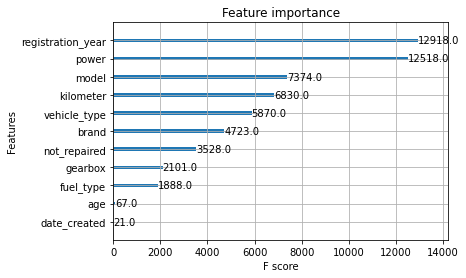

In [81]:
xgb.plot_importance(xgbreg2); 

In [82]:
# функция для вывода таблицы с признаками в порядке убывания важности
def xgb_feature_select(model):
    feature_important = model.get_booster().get_score()

    feature_imp = pd.DataFrame(columns=['value', 'feature'])
    feature_imp['value'] = list(feature_important.values())
    feature_imp['feature'] = list(feature_important.keys())
    feature_imp = feature_imp.sort_values('value', ascending=False)
    return feature_imp

In [83]:
feature_imp = xgb_feature_select(xgbreg2)
feature_imp

,value,feature
1,12918.0,registration_year
3,12518.0,power
4,7374.0,model
5,6830.0,kilometer
0,5870.0,vehicle_type
7,4723.0,brand
8,3528.0,not_repaired
2,2101.0,gearbox
6,1888.0,fuel_type
10,67.0,age


Обучим модель с использованием 5 самых важных признаков.

In [84]:
top_features = 5
train_features = train_features[list(feature_imp['feature'][:top_features])]

In [85]:
fit_predict(xgbreg2, name='xgbreg2', importance_features=top_features)
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(random_state=123),0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, num_iterations=500,...",1.6,1279,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.0,1360,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,105.8,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,15.4,1319,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.0,1282,all
0,cbreg3,<catboost.core.CatBoostRegressor object at 0x0...,6.4,1508,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,27.5,1417,6
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",4.7,1301,all


**Вывод:**

Модель XGBRegressor() показала наименьшее значение ошибки RMSE среди других моделей, которые были исследованы выше.

Корректировка гиперпараметров привела к уменьшению времени обучения модели (примерно в 3 раза), но при этом значительно увеличилась ошибка. 

Уменьшение количества признаков привело к уменьшению времени обучения модели, но при этом ошибка увеличилась.

### LinearRegression

In [86]:
train_features, train_target, test_features, test_target = split_df(df_ohe, 'price')

In [87]:
linear = LinearRegression()

In [88]:
fit_predict(linear, name='linear')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(random_state=123),0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, num_iterations=500,...",1.6,1279,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.0,1360,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,105.8,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,15.4,1319,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.0,1282,all
0,cbreg3,<catboost.core.CatBoostRegressor object at 0x0...,6.4,1508,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,27.5,1417,6
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",4.7,1301,all


**Вывод:**

Модель линейной регрессии показала более высокую ошибку, чем модели градиентного бустинга. 

## Анализ моделей

Отсортируем таблицу с результатами по величине ошибки RMSE. Посмотрим на соотношение времени выполнения и величины ошибки RMSE. Выберем три лучшие модели.

In [89]:
result_tbl.sort_values('RMSE')

,model_name,model,fit_time_sec,RMSE,importance_features
0,xgbreg2,"XGBRegressor(base_score=0.5, booster='gbtree',...",7.7,1033,all
0,xgbreg2,"XGBRegressor(base_score=0.5, booster='gbtree',...",5.6,1162,5
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, num_iterations=500,...",1.6,1279,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.0,1282,all
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",4.7,1301,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,15.4,1319,all
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,105.8,1320,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.0,1360,5
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,27.5,1417,6


Протестируем следующие три модели. Посчитаем время, затраченное на получение предсказаний.
- xgbreg2 = XGBRegressor(max_depth=10, random_state=123)
- xgbreg2 = XGBRegressor(max_depth=10, random_state=123) с отбором 5 признаков
- lgbmreg2 = LGBMRegressor(num_iterations=1000, max_bin=255, random_state=123)

In [90]:
# таблица для накопления результатов тестирования
columns = ['model_name', 'model', 'predict_time_sec', 'RMSE']
result_tbl2 = pd.DataFrame(columns=columns)
result_tbl2

,model_name,model,predict_time_sec,RMSE


Значения полей таблицы с результатами:
- **model_name** – название модели,
- **model** – конфигурация модели,
- **predict_time_sec** – время, за которое получены предсказания, в секундах,
- **RMSE** – среднеквадратическая ошибка на тестовой выборке.

In [91]:
# функция для тестирования модели и расчета времени, за которое получены предсказания
def test(model, name):
    model.fit(train_features, train_target)
    
    start_predict_time = time.time()
    predictions = model.predict(test_features)
    predict_time = time.time() - start_predict_time
    
    global a
    columns = ['model_name', 'model', 'predict_time_sec', 'RMSE']
    rows = [[name, model, round(predict_time, 1), int(rmse(test_target, predictions))]]
    a = pd.DataFrame(data=rows, columns=columns)

In [92]:
train_features, train_target, test_features, test_target = split_df(df_ordinal, 'price')

In [93]:
test(xgbreg2, name='xgbreg2')
result_tbl2 = pd.concat([result_tbl2, a], axis = 0) # добавление показателей в общую таблицу

In [94]:
test(lgbmreg2, name='lgbmreg2')
result_tbl2 = pd.concat([result_tbl2, a], axis = 0) # добавление показателей в общую таблицу

C:\Users\79853\miniconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [95]:
# отбор признаков
feature_imp = xgb_feature_select(xgbreg2)
top_features = 5
train_features = train_features[list(feature_imp['feature'][:top_features])]
test_features = test_features[list(feature_imp['feature'][:top_features])]

In [96]:
test(xgbreg2, name='xgbreg2 (5 features)')
result_tbl2 = pd.concat([result_tbl2, a], axis = 0) # добавление показателей в общую таблицу

In [97]:
result_tbl2

,model_name,model,predict_time_sec,RMSE
0,xgbreg2,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.1,1365
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",0.7,1345
0,xgbreg2 (5 features),"XGBRegressor(base_score=0.5, booster='gbtree',...",0.1,1464


В совокупности показателей на обучении и тестировании лучшей является модель:
- **lgbmreg2 = LGBMRegressor(num_iterations=1000, max_bin=255, random_state=123)**

In [98]:
print("\033[1m" + "Результаты выбранной модели на этапе обучения" + "\033[0;0m")
result_tbl.loc[(result_tbl.model_name == 'lgbmreg2') & (result_tbl.importance_features == 'all')]

Результаты выбранной модели на этапе обучения


,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",3.3,1216,all


In [99]:
print("\033[1m" + "Результаты выбранной модели на этапе тестирования" + "\033[0;0m")
result_tbl2.loc[result_tbl2.model_name == 'lgbmreg2']

Результаты выбранной модели на этапе тестирования


,model_name,model,predict_time_sec,RMSE
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_iterations=1000...",0.7,1345


## Общий вывод

В ходе проекта были исследованы исторические данные сервиса по продаже автомобилей: технические характеристики, комплектации и цены автомобилей, - с целью построения модели для определения стоимости.

На этапе **подготовки данных** были удалены поля, не влияющие на целевой признак, выявлены и удалены явные дубликаты, обработаны пропуски и некорректные значения в данных, категориальные признаки преобразованы в численные при помощи техник OHE и OrdinalEncoder.

В **п.2** было обучено три модели градиентного бустинга: 
- **LGBMRegressor()**,
- **CatBoostRegressor()**,
- **XGBRegressor()**.

Было рассмотрено качество и скорость работы моделей градиентного бустинга по следующему алгоритму:
- обучена модель со значениями гиперпараметров по умолчанию;
- подобраны значения нескольких гиперпараметров, которые влияют как на качество, так и на скорость обучения, с помощью GridSearchCV();
- обучена модель с подобранными гиперпараметрами;
- увеличена скорость работы модели корректировкой гиперпараметров;
- увеличена скорость работы модели отбором признаков.

Для сравнения также была обучена модель линейной регрессии **LinearRegression()**.

Лучшие результаты показала модель **LGBMRegressor(num_iterations=1000, max_bin=255, random_state=123)**:
- время обучения - 3 секунд,
- время предсказания - 1 секунда,
- RMSE на обучающей выборке - 1216,
- RMSE на тестовой выборке - 1345.